In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from os import path

from compton import create_observable_set, proton_pol_vec_std, proton_pol_vec_mean
from compton import proton_pol_vec_trans_std, proton_pol_vec_trans_mean

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

In [3]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [4]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
observables_unique = df['observable'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [5]:
from sklearn.utils.extmath import cartesian
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

In [6]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

We must make the transformation
\begin{align*}
\vec{\xi} \to \vec{\xi}' \equiv P \vec{\xi}
\end{align*}
that is
\begin{align*}
\begin{bmatrix}
\alpha + \beta \\
\alpha - \beta \\
\gamma_0 \\
\gamma_\pi \\
\gamma_{E-} \\
\gamma_{M-}
\end{bmatrix}
\equiv
\begin{bmatrix}
    1 &  1 &  0 &  0 &  0 &  0 \\
    1 & -1 &  0 &  0 &  0 &  0 \\
    0 &  0 & -1 & -1 & -1 & -1 \\
    0 &  0 & -1 &  1 & -1 &  1 \\
    0 &  0 &  1 &  0 & -1 &  0 \\
    0 &  0 &  0 &  1 &  0 & -1
\end{bmatrix}
\begin{bmatrix}
\alpha \\ \beta \\ \gamma_{E1E1} \\ \gamma_{M1M1} \\ \gamma_{E1M2} \\ \gamma_{M1E2}
\end{bmatrix}
\end{align*}
This is not an orthogonal transformation so we should not expect that the utility function will be invariant under this change of basis.

In [7]:
P = np.array([
    [1,  1,  0,  0,  0,  0],
    [1, -1,  0,  0,  0,  0],
    [0,  0, -1, -1, -1, -1],
    [0,  0, -1,  1, -1,  1],
    [0,  0,  1,  0, -1,  0],
    [0,  0,  0,  1,  0, -1]
])
P_inv = np.linalg.inv(P)

In [8]:
from itertools import combinations, product

data_combs = np.asarray(list(combinations(range(len(X)), 1)))

In [9]:
X_mask = (X[:, 0] == 15) & np.isin(X[:, 1], [15, 20, 25])
print(X_mask, '\n', X[X_mask])

[False False False ... False False False] 
 [[15. 15.]
 [15. 20.]
 [15. 25.]]


In [10]:
np.where(X_mask)

(array([77, 78, 79]),)

In [11]:
data_combs

array([[   0],
       [   1],
       [   2],
       ...,
       [2735],
       [2736],
       [2737]])

## Checking if the utility is invariant under change of polarizations

hint: it is not.

In [12]:
cov_p_proton = np.diag(proton_pol_vec_std)
cov_p_proton_mapped = P @ cov_p_proton @ P.T

In [13]:
compton_obs = create_observable_set(df=df, cov_exp=sd_exp**2, cov_p_proton=cov_p_proton)
compton_obs_mapped = create_observable_set(df=df, cov_exp=sd_exp**2, p_transform=P, cov_p_proton=cov_p_proton_mapped)

In [14]:
np.linalg.det(cov_p_proton)

0.11240901846048648

In [15]:
np.linalg.det(cov_p_proton_mapped)

28.776708725884532

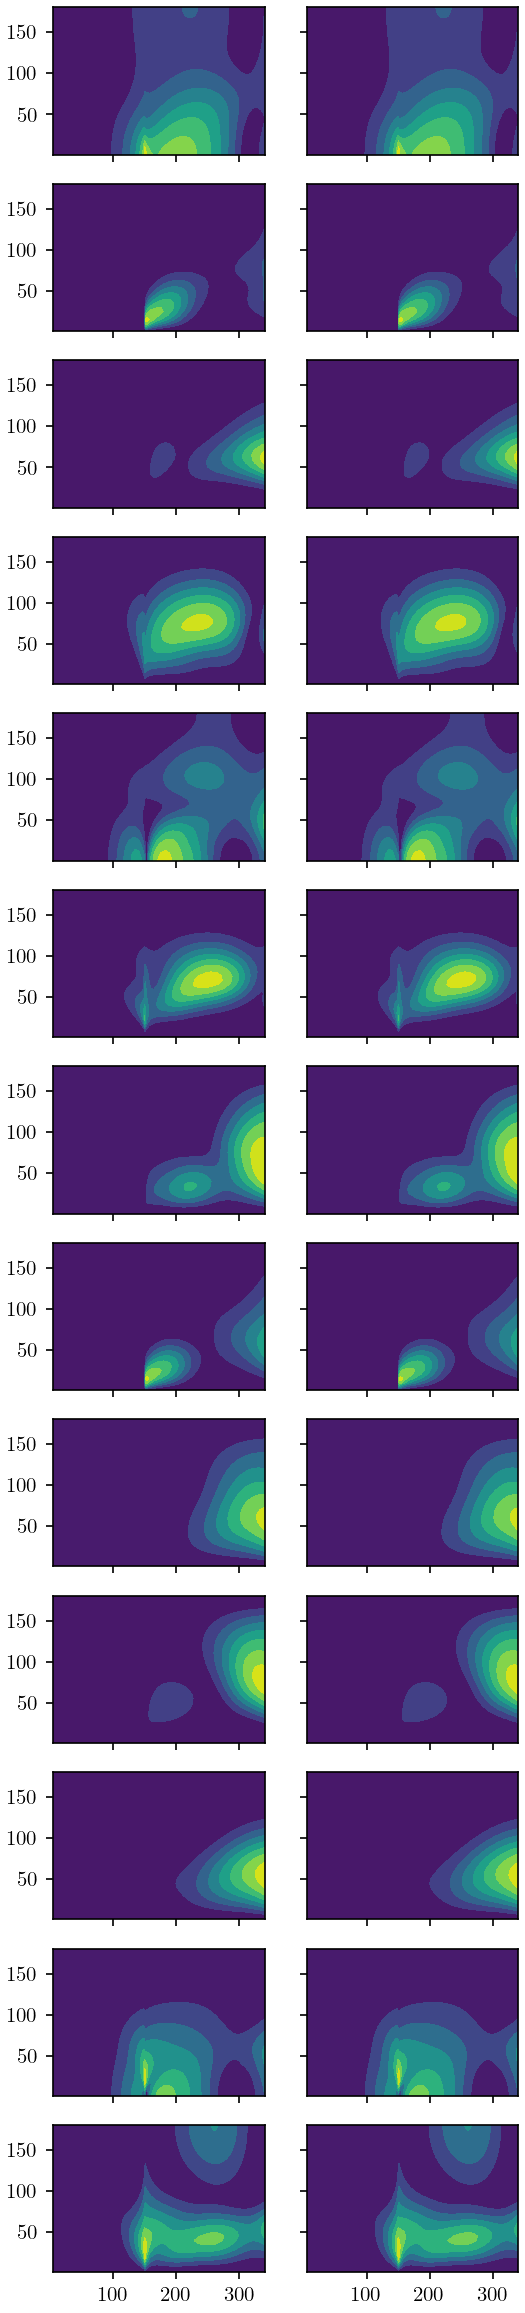

In [16]:
fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 20), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton']):
        ax = axes[i, j]
        order_i = 4
        compton_i = compton_obs[obs_i, nucleon_j, order_i, 'linear']
        compton_mapped_i = compton_obs_mapped[obs_i, nucleon_j, order_i, 'linear']

        util_i = np.zeros(data_combs.shape, dtype=float)
        util_i_mapped = np.zeros(data_combs.shape, dtype=float)
        for k, idx_k in enumerate(data_combs):
            util_i[k] = compton_i.utility_linear(idx_k)
            util_i_mapped[k] = compton_mapped_i.utility_linear(idx_k)

        axes[i, 0].contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        axes[i, 1].contourf(omega_lab_unique, degrees_lab_unique, util_i_mapped.reshape(n_omega, n_angle).T)

## Check subsets of polarizabilities

In [17]:
subsets = {'all': [0, 1, 2, 3, 4, 5], r'$\alpha+\beta$': [0], r'$\alpha-\beta$': [1], r'$\gamma_i$s': [2, 3, 4, 5]}

In [18]:
from compton import RBFJump, expansion_parameter_transfer_cm, mass_proton, order_transition

breakdown = 650
# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 2
omitted_order = order_transition(5, 2, X[:, 0])
Q = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)
Q_sum = np.zeros((Q.shape[0], Q.shape[0]))
for i in range(100):
    Qi = Q**(omitted_order+i)
    Q_sum += Qi[:, None] * Qi
    
corr_mat = np.eye(Q.shape[0])
R_mat = Q_sum * corr_mat

cov_trunc = sd_exp**2 * np.eye(len(X)) + R_mat

In [19]:
cov_p_proton_trans = np.diag(proton_pol_vec_trans_std)
compton_obs_trans = create_observable_set(df=df, cov_exp=sd_exp**2, p_transform=P, cov_p_proton=cov_p_proton_trans)
compton_obs_trans_trunc = create_observable_set(df=df, cov_exp=cov_trunc, p_transform=P, cov_p_proton=cov_p_proton_trans)

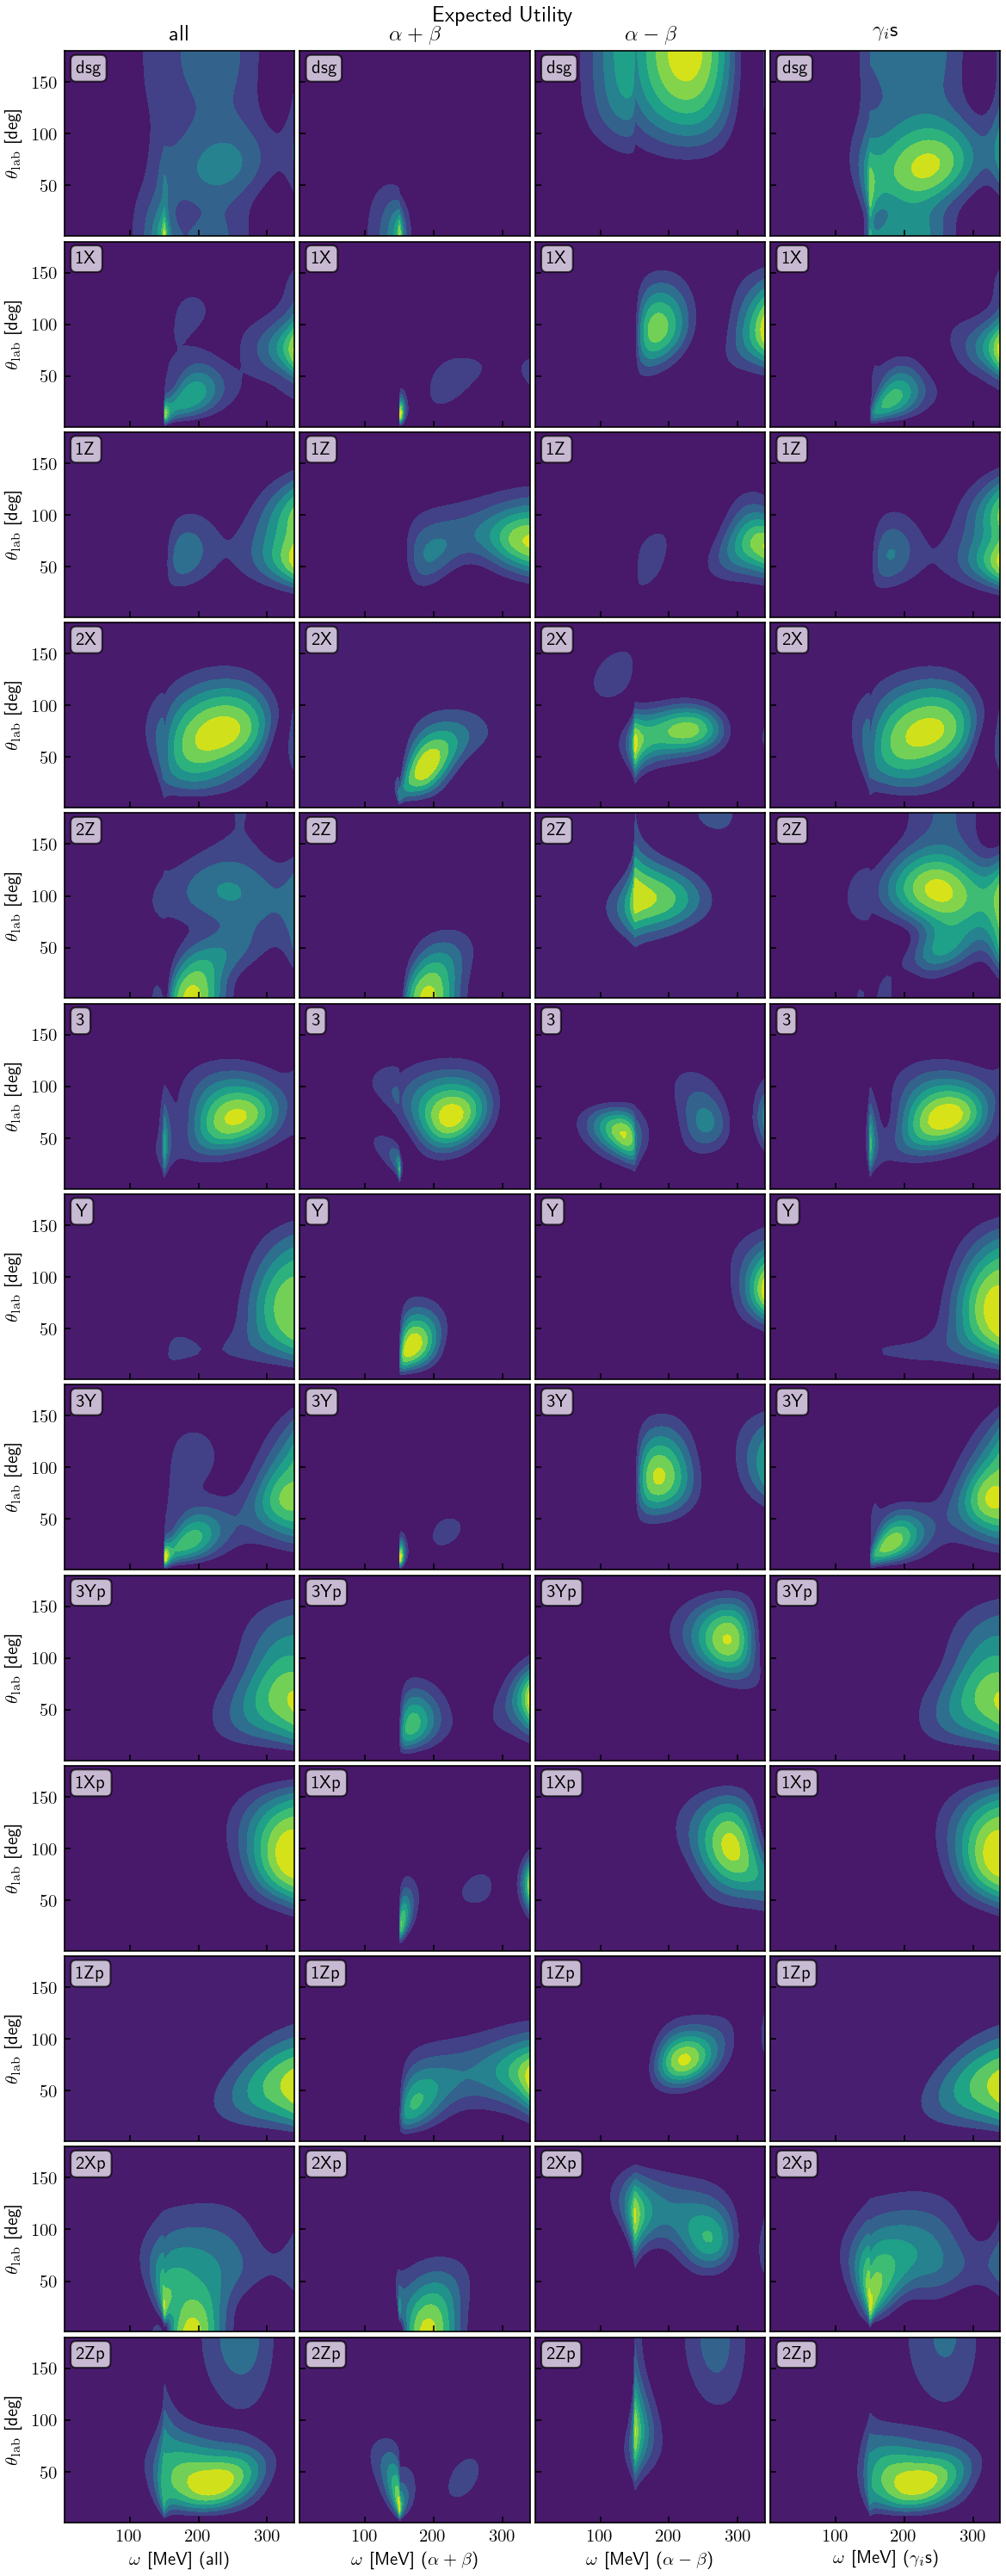

In [20]:
util_dict_trans_sets = {}

fig, axes = plt.subplots(len(observables_unique), len(subsets), figsize=(8, 20), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, (subset_name, subset) in enumerate(subsets.items()):
        order_i = 4
        compton_i = compton_obs_trans[obs_i, 'proton', order_i, 'linear']

        util_i = np.zeros(data_combs.shape, dtype=float)
        for k, idx_k in enumerate(data_combs):
            util_i[k] = compton_i.utility_linear(idx_k, p_idx=subset, only_log=False)
        util_dict_trans_sets[obs_i, subset_name] = util_i

for i, obs_i in enumerate(observables_unique):
    # Same colors within rows
    # max_util = np.max([util_dict_trans_sets[obs_i, subset_name] for subset_name in subsets.keys()])
    # min_util = np.min([util_dict_trans_sets[obs_i, subset_name] for subset_name in subsets.keys()])

    # Same colors for all plots
    # max_util = np.max([u for u in util_dict_trans_sets.values()])
    # min_util = np.min([u for u in util_dict_trans_sets.values()])
    
    # Each plot has own colors
    max_util = None
    min_util = None

    for j, (subset_name, subset) in enumerate(subsets.items()):
        # Same colors within columns
#         max_util = np.max([util_dict_trans_sets[o, subset_name] for o in observables_unique])
#         min_util = np.min([util_dict_trans_sets[o, subset_name] for o in observables_unique])

        ax = axes[i, j]
        util_i = util_dict_trans_sets[obs_i, subset_name]
        ax.contourf(
            omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T,
            vmin=min_util, vmax=max_util
        )
        
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        ax.text(
            0.05, 0.95, text, transform=ax.transAxes,
            bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')
        if i == len(observables_unique)-1:
            ax.set_xlabel(fr'$\omega$ [MeV] ({subset_name})')
        if j == 0:
            ax.set_ylabel(r'$\theta_{\rm lab}$ [deg]')
        ax.tick_params(direction='in')
        if i == 0:
            ax.set_title(subset_name)
            
fig.suptitle('Expected Utility', y=1)
fig.tight_layout(h_pad=0.3, w_pad=0.3)
fig.savefig('figures/utility_proton_subsets_transformed.pdf')

In [21]:
from matplotlib import ticker

all 1.0 2.911851761591736 [1.         1.19118518 1.38237035 1.57355553 1.7647407  1.95592588
 2.14711106 2.33829623 2.52948141 2.72066659 2.91185176]
$\alpha+\beta$ 1.0 2.7500266847508934 [1.         1.17500267 1.35000534 1.52500801 1.70001067 1.87501334
 2.05001601 2.22501868 2.40002135 2.57502402 2.75002668]
$\alpha-\beta$ 1.0 1.0615706442307993 [1.         1.00615706 1.01231413 1.01847119 1.02462826 1.03078532
 1.03694239 1.04309945 1.04925652 1.05541358 1.06157064]
$\gamma_i$s 1.0 1.5255383448988933 [1.         1.05255383 1.10510767 1.1576615  1.21021534 1.26276917
 1.31532301 1.36787684 1.42043068 1.47298451 1.52553834]


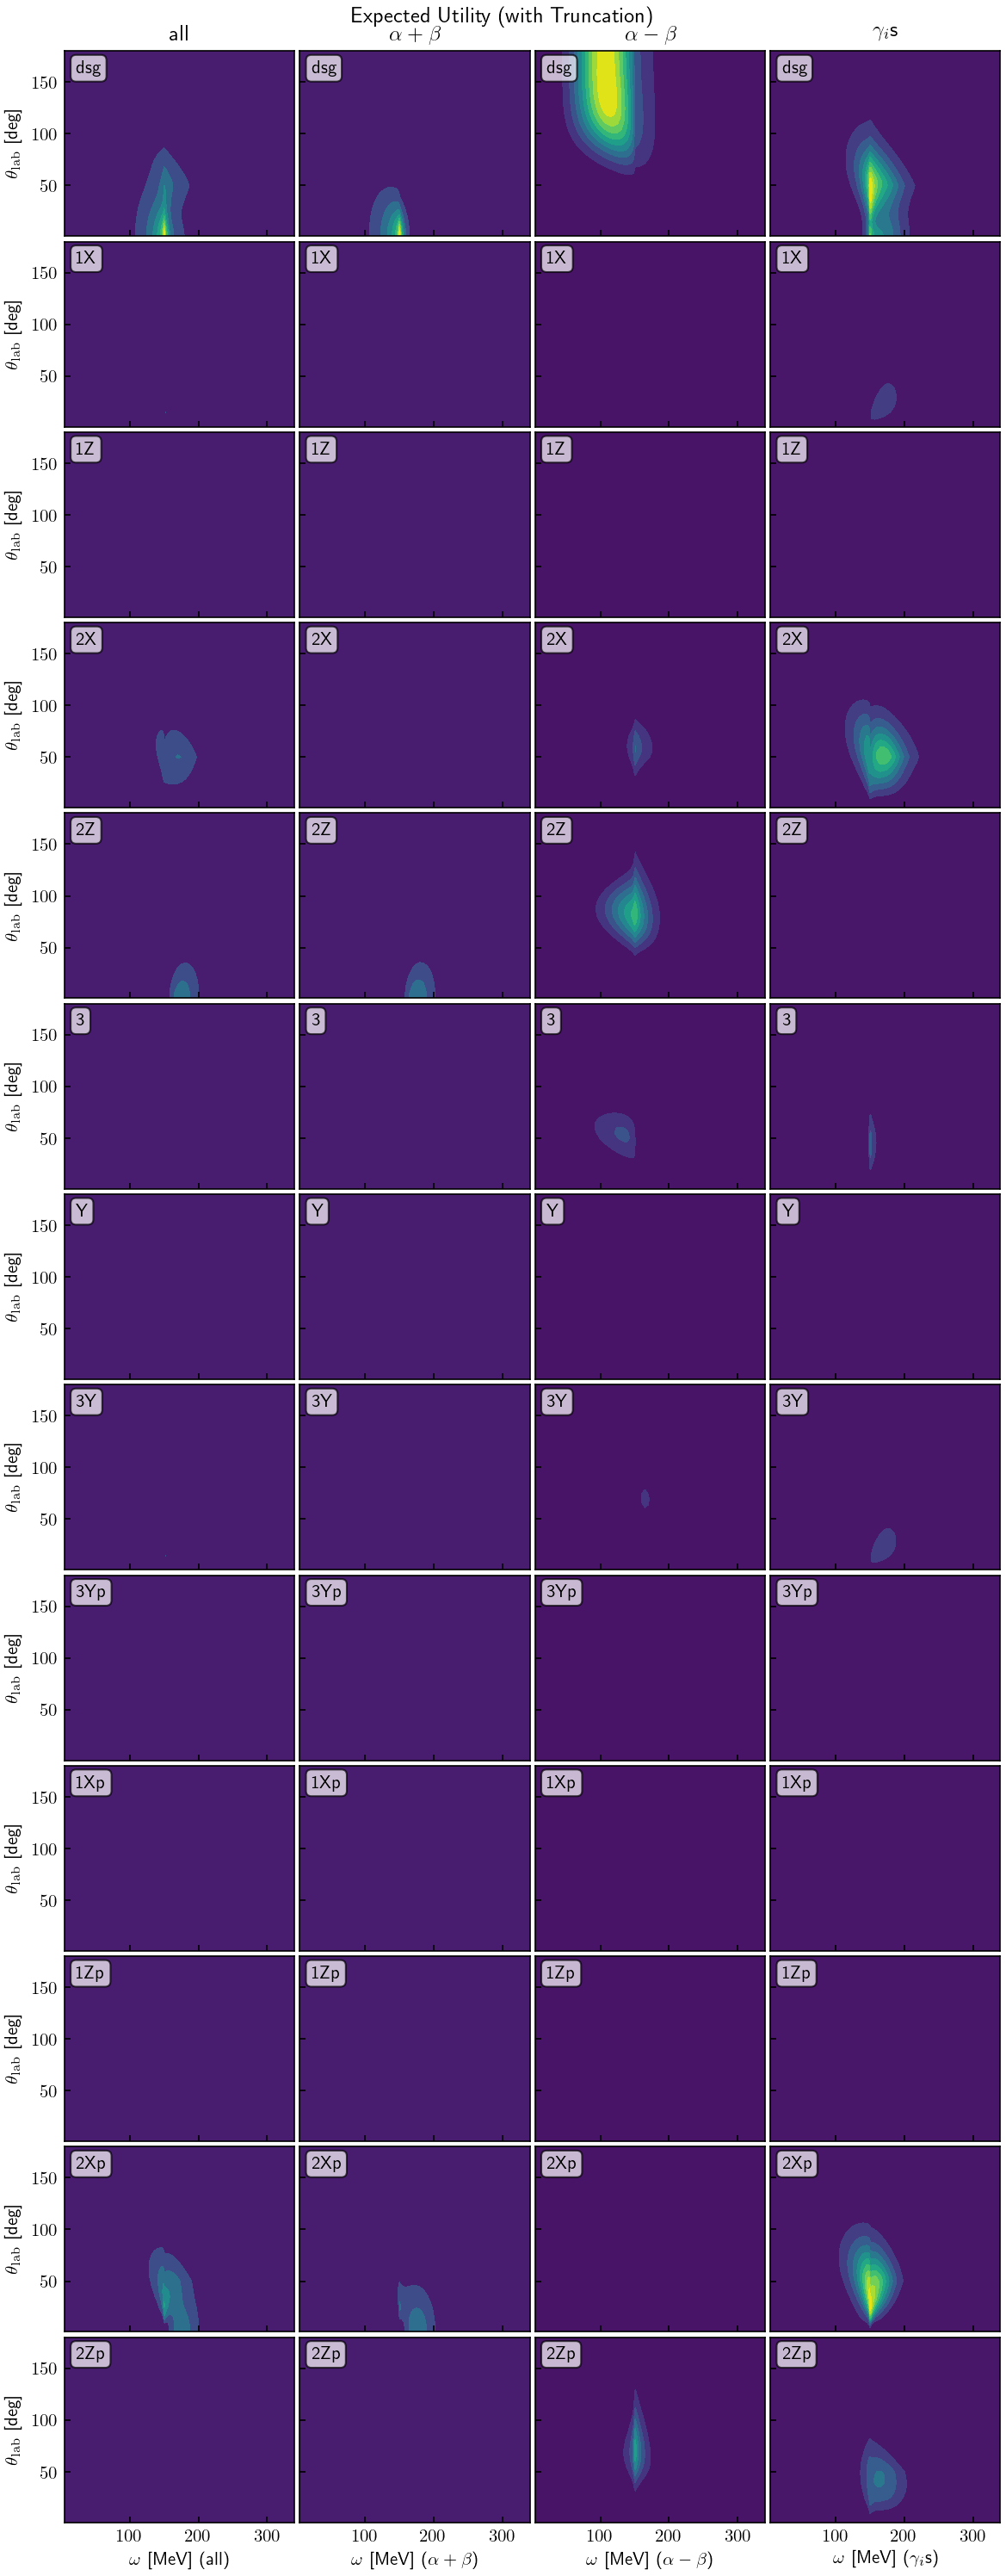

In [22]:
util_dict_trans_trunc_sets = {}
util_dict_trans_trunc_sets_bests = {}

fig, axes = plt.subplots(len(observables_unique), len(subsets), figsize=(8, 20), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, (subset_name, subset) in enumerate(subsets.items()):
        order_i = 4
        compton_i = compton_obs_trans_trunc[obs_i, 'proton', order_i, 'linear']

        util_i = np.zeros(data_combs.shape, dtype=float)
        for k, idx_k in enumerate(data_combs):
            util_i[k] = compton_i.utility_linear(idx_k, p_idx=subset, only_log=False)
        util_dict_trans_trunc_sets[obs_i, subset_name] = util_i
        trunc_bests_1pt_i = {}
        idx_ij = np.argmax(util_i)
        trunc_bests_1pt_i['idx'] = idx_ij
        trunc_bests_1pt_i['util'] = np.max(util_i)
        trunc_bests_1pt_i['omega'] = X[idx_ij, 0]
        trunc_bests_1pt_i['theta'] = X[idx_ij, 1]
        util_dict_trans_trunc_sets_bests[obs_i, subset_name] = trunc_bests_1pt_i

for i, obs_i in enumerate(observables_unique):
    # Same colors within rows
    # max_util = np.max([util_dict_trans_trunc_sets[obs_i, subset_name] for subset_name in subsets.keys()])
    # min_util = np.min([util_dict_trans_trunc_sets[obs_i, subset_name] for subset_name in subsets.keys()])

    # Same colors for all plots
#     max_util = np.max([u for u in util_dict_trans_trunc_sets.values()])
#     min_util = np.min([u for u in util_dict_trans_trunc_sets.values()])
#     if i == 0:
#         print(max_util)
#         print(np.exp(max_util))
#     min_util = np.exp(min_util)
#     max_util = np.exp(max_util)
    
    # Each plot has own colors
    max_util = None
    min_util = None

    for j, (subset_name, subset) in enumerate(subsets.items()):
        # Same colors within columns
        max_util = np.max([util_dict_trans_trunc_sets[o, subset_name] for o in observables_unique])
        min_util = np.min([util_dict_trans_trunc_sets[o, subset_name] for o in observables_unique])
        min_util = np.exp(min_util)
        max_util = np.exp(max_util)

        ax = axes[i, j]
        util_i = util_dict_trans_trunc_sets[obs_i, subset_name]
        util_i = np.exp(util_i)
        
        levels = None
        levels = np.linspace(np.floor(min_util), max_util, 11)
        if i == 0:
            print(subset_name, min_util, max_util, levels)
#         print(levels)
        
        ax.contourf(
            omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T,
            vmin=min_util, vmax=max_util,
            locator=ticker.LogLocator(),
#             levels=np.log(np.arange(1, max_util+0.25, 0.25)),
#             levels=np.arange(1, max_util+0.25, 0.25),
            levels=levels
        )
        
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        ax.text(
            0.05, 0.95, text, transform=ax.transAxes,
            bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')
        if i == len(observables_unique)-1:
            ax.set_xlabel(fr'$\omega$ [MeV] ({subset_name})')
        if j == 0:
            ax.set_ylabel(r'$\theta_{\rm lab}$ [deg]')
        ax.tick_params(direction='in')
        if i == 0:
            ax.set_title(subset_name)
            
fig.suptitle('Expected Utility (with Truncation)', y=1)
fig.tight_layout(h_pad=0.3, w_pad=0.3)
fig.savefig('figures/utility_proton_subsets_transformed_trunc.pdf')

In [23]:
util_dict_trans_trunc_sets_bests

{('crosssection', 'all'): {'idx': 1184,
  'util': 1.0687892229918887,
  'omega': 149.95069260447417,
  'theta': 1.0},
 ('crosssection', '$\\alpha+\\beta$'): {'idx': 1184,
  'util': 1.0116106151771802,
  'omega': 149.95069260447417,
  'theta': 1.0},
 ('crosssection', '$\\alpha-\\beta$'): {'idx': 806,
  'util': 0.05974955127108433,
  'omega': 110.0,
  'theta': 145.0},
 ('crosssection', '$\\gamma_i$s'): {'idx': 1230,
  'util': 0.4223473608133834,
  'omega': 151.0,
  'theta': 45.0},
 ('1X', 'all'): {'idx': 1261,
  'util': 0.17695661325008383,
  'omega': 152.0,
  'theta': 15.0},
 ('1X', '$\\alpha+\\beta$'): {'idx': 1261,
  'util': 0.13596601341467285,
  'omega': 152.0,
  'theta': 15.0},
 ('1X', '$\\alpha-\\beta$'): {'idx': 1420,
  'util': 0.005777690021843397,
  'omega': 165.0,
  'theta': 70.0},
 ('1X', '$\\gamma_i$s'): {'idx': 1410,
  'util': 0.09469370643298997,
  'omega': 165.0,
  'theta': 20.0},
 ('1Z', 'all'): {'idx': 1453,
  'util': 0.03155658536252559,
  'omega': 170.0,
  'theta': 50

In [24]:
df_bests_1pt_trunc = pd.DataFrame.from_dict(util_dict_trans_trunc_sets_bests).T
df_bests_1pt_trunc.index.names = 'observable', 'subset'
df_bests_1pt_trunc = df_bests_1pt_trunc.reset_index()
df_bests_1pt_trunc['idx'] = df_bests_1pt_trunc.astype({'idx': 'int32'})['idx']
df_bests_1pt_trunc['shrinkage'] = np.exp(df_bests_1pt_trunc['util'])
df_bests_1pt_trunc

,observable,subset,idx,util,omega,theta,shrinkage
0,crosssection,all,1184,1.068789,149.950693,1.0,2.911852
1,crosssection,$\alpha+\beta$,1184,1.011611,149.950693,1.0,2.750027
2,crosssection,$\alpha-\beta$,806,0.059750,110.000000,145.0,1.061571
3,crosssection,$\gamma_i$s,1230,0.422347,151.000000,45.0,1.525538
4,1X,all,1261,0.176957,152.000000,15.0,1.193579
5,1X,$\alpha+\beta$,1261,0.135966,152.000000,15.0,1.145643
6,1X,$\alpha-\beta$,1420,0.005778,165.000000,70.0,1.005794
7,1X,$\gamma_i$s,1410,0.094694,165.000000,20.0,1.099322
8,1Z,all,1453,0.031557,170.000000,50.0,1.032060
9,1Z,$\alpha+\beta$,1490,0.003081,175.000000,50.0,1.003085


In [26]:
import seaborn as sns

In [27]:
from matplotlib import gridspec as gs

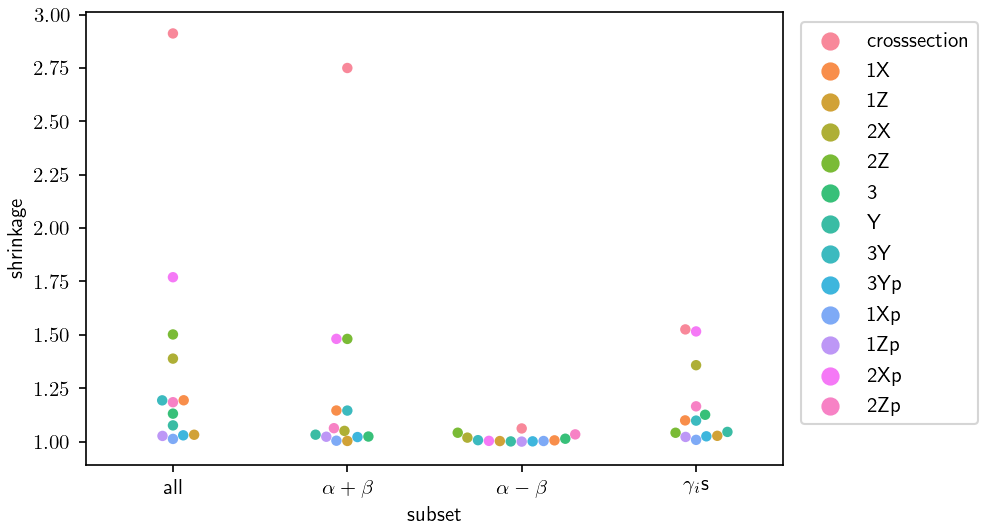

In [28]:
sns.swarmplot(
    x='subset', y='shrinkage', data=df_bests_1pt_trunc,
    hue='observable', #marker=list(df_bests_1pt_trunc['observable'].values)
)
plt.legend().set_bbox_to_anchor((1.01, 1))

In [29]:
util_dict_trans_trunc_sets

{('crosssection', 'all'): array([[5.60741611e-07],
        [5.60664118e-07],
        [5.60415427e-07],
        ...,
        [1.95998810e-06],
        [1.71202870e-06],
        [1.63590680e-06]]),
 ('crosssection', '$\\alpha+\\beta$'): array([[5.60741602e-07],
        [5.60664109e-07],
        [5.60415413e-07],
        ...,
        [4.99600361e-16],
        [0.00000000e+00],
        [0.00000000e+00]]),
 ('crosssection', '$\\alpha-\\beta$'): array([[0.00000000e+00],
        [0.00000000e+00],
        [4.19109192e-15],
        ...,
        [4.30957918e-07],
        [3.74700662e-07],
        [3.57395007e-07]]),
 ('crosssection', '$\\gamma_i$s'): array([[9.54791801e-15],
        [9.54791801e-15],
        [9.99200722e-15],
        ...,
        [1.52903150e-06],
        [1.33732904e-06],
        [1.27851271e-06]]),
 ('1X', 'all'): array([[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [6.15398748e-08],
        [1.38442222e-08],
        [0.00000000e+00

In [30]:
/.

SyntaxError: invalid syntax (<ipython-input-30-8220ccc57e03>, line 1)

In [31]:
len(list(combinations(degrees_lab_unique, 2)))

666

In [32]:
len(degrees_lab_unique)

37

In [33]:
from math import factorial

In [34]:
factorial(37) / (factorial(37 - 5) * factorial(5))

435897.0

In [35]:
435897 * len(omega_lab_unique)

32256378

In [36]:
degrees_lab_unique

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180])

In [37]:
X_reduced = X[(X[:, 1] > 30) & (X[:, 1] < 150) & (X[:, 0] > 50)]
X_reduced = X_reduced[(X_reduced[:, 0] % 2 == 0) & (X_reduced[:, 1] % 2 == 0)]
omega_lab_reduced_unique = np.unique(X_reduced[:, 0])
degrees_lab_reduced_unique = np.unique(X_reduced[:, 1])

In [38]:
X_reduced

array([[ 60.,  40.],
       [ 60.,  50.],
       [ 60.,  60.],
       [ 60.,  70.],
       [ 60.,  80.],
       [ 60.,  90.],
       [ 60., 100.],
       [ 60., 110.],
       [ 60., 120.],
       [ 60., 130.],
       [ 60., 140.],
       [ 70.,  40.],
       [ 70.,  50.],
       [ 70.,  60.],
       [ 70.,  70.],
       [ 70.,  80.],
       [ 70.,  90.],
       [ 70., 100.],
       [ 70., 110.],
       [ 70., 120.],
       [ 70., 130.],
       [ 70., 140.],
       [ 80.,  40.],
       [ 80.,  50.],
       [ 80.,  60.],
       [ 80.,  70.],
       [ 80.,  80.],
       [ 80.,  90.],
       [ 80., 100.],
       [ 80., 110.],
       [ 80., 120.],
       [ 80., 130.],
       [ 80., 140.],
       [ 90.,  40.],
       [ 90.,  50.],
       [ 90.,  60.],
       [ 90.,  70.],
       [ 90.,  80.],
       [ 90.,  90.],
       [ 90., 100.],
       [ 90., 110.],
       [ 90., 120.],
       [ 90., 130.],
       [ 90., 140.],
       [100.,  40.],
       [100.,  50.],
       [100.,  60.],
       [100.,

In [39]:
len(X_reduced)

330

In [40]:
degrees_lab_reduced_unique

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [41]:
omega_lab_reduced_unique

array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 148., 152.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340.])

In [42]:
len(list(combinations(degrees_lab_reduced_unique, 5)))

462

In [43]:
subset

[2, 3, 4, 5]

In [44]:
n_angle_search = 1


# best_util = -np.inf
# best_idxs = None
# best_obs = None
# subset_name = 'all'
# subset_name = r'$\alpha-\beta$'
# subset = subsets[subset_name]

util_bests_npts = {}

subset_savenames = {'all': 'all', r'$\alpha-\beta$': 'amb', r'$\alpha+\beta$': 'apb', r'$\gamma_i$s': 'gammas'}

for subset_name, subset in subsets.items():
    bests = {obs: dict(util=-np.inf) for obs in observables_unique}
    print(subset_name)
    for aa, angles in enumerate(combinations(degrees_lab_reduced_unique, n_angle_search)):
        if aa % 100 == 0:
            print(aa)
        for energy in omega_lab_reduced_unique:
            for obs_i in observables_unique:
    #             idxs = np.where((X_reduced[:, 0] == energy) & np.isin(X_reduced[:, 1], angles))[0]
                # The observable object is set up to only know about X
                idxs = np.where((X[:, 0] == energy) & np.isin(X[:, 1], angles))[0]
                order_i = 4
                compton_i = compton_obs_trans_trunc[obs_i, 'proton', order_i, 'linear']
                current_util = compton_i.utility_linear(idxs, p_idx=subset, only_log=False)
                if current_util > bests[obs_i]['util']:
                    bests_i = bests[obs_i]
                    bests_i['util'] = current_util
                    bests_i['idxs'] = idxs
                    bests_i['omega'] = X[idxs, 0]
                    bests_i['theta'] = X[idxs, 1]
                    util_bests_npts[obs_i, subset_name] = bests_i

print(bests)
print(util_bests_npts)
# print(best_idxs)

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$s
0
{'crosssection': {'util': 0.40438389624096427, 'idxs': array([1268]), 'omega': array([152.]), 'theta': array([50.])}, '1X': {'util': 0.05591377879643089, 'idxs': array([1525]), 'omega': array([180.]), 'theta': array([40.])}, '1Z': {'util': 0.026741700639129562, 'idxs': array([1453]), 'omega': array([170.]), 'theta': array([50.])}, '2X': {'util': 0.30598695364894324, 'idxs': array([1453]), 'omega': array([170.]), 'theta': array([50.])}, '2Z': {'util': 0.03845481526842287, 'idxs': array([1017]), 'omega': array([140.]), 'theta': array([90.])}, '3': {'util': 0.1019926415408619, 'idxs': array([1268]), 'omega': array([152.]), 'theta': array([50.])}, 'Y': {'util': 0.03307399344536943, 'idxs': array([1377]), 'omega': array([160.]), 'theta': array([40.])}, '3Y': {'util': 0.05198987650889936, 'idxs': array([1525]), 'omega': array([180.]), 'theta': array([40.])}, '3Yp': {'util': 0.02261999325851849, 'idxs': array([2709]), 'omega': array([340.]

In [45]:
bests_npts = pd.DataFrame.from_dict(util_bests_npts).T
bests_npts.index.names = 'observable', 'subset'
bests_npts = bests_npts.reset_index()
# bests_npts['idx'] = bests_npts.astype({'idx': 'int32'})['idx']
bests_npts['util'] = bests_npts.astype({'util': 'float64'})['util']
bests_npts['shrinkage'] = np.exp(bests_npts['util'])
bests_npts

,observable,subset,util,idxs,omega,theta,shrinkage
0,crosssection,all,0.459303,[1266],[152.0],[40.0],1.582970
1,1X,all,0.058568,[1525],[180.0],[40.0],1.060317
2,1Z,all,0.031557,[1453],[170.0],[50.0],1.032060
3,2X,all,0.328390,[1453],[170.0],[50.0],1.388730
4,2Z,all,0.137258,[1525],[180.0],[40.0],1.147124
5,3,all,0.106687,[1268],[152.0],[50.0],1.112586
6,Y,all,0.059346,[1377],[160.0],[40.0],1.061142
7,3Y,all,0.054666,[1525],[180.0],[40.0],1.056188
8,3Yp,all,0.028982,[1453],[170.0],[50.0],1.029406
9,1Xp,all,0.012024,[1379],[160.0],[50.0],1.012097


In [46]:
# bests_df = pd.DataFrame.from_dict(bests).T
# bests_df.index.name = 'observable'
# bests_df = bests_df.reset_index()
# bests_df['subset'] = subset_name

In [47]:
# bests_df

In [48]:
# bests_df.max()

In [49]:
idxs_flat = []
omega_flat = []
theta_flat = []
obs_flat = []
subset_flat = []
util_flat = []

for (obs, subset), best in util_bests_npts.items():
    idxs_flat = idxs_flat + list(best['idxs'])
    omega_flat = omega_flat + list(best['omega'])
    theta_flat = theta_flat + list(best['theta'])
    obs_flat = obs_flat + [obs for i in range(len(best['idxs']))]
    subset_flat = subset_flat + [subset for i in range(len(best['idxs']))]
    util_flat = util_flat + [best['util'] for i in range(len(best['idxs']))]
    
bests_df_flat = pd.DataFrame(
    {'idx': idxs_flat, 'omega': omega_flat, 'theta': theta_flat,
     'observable': obs_flat, 'util': util_flat, 'subset': subset_flat}
)

In [50]:
bests_df_flat

,idx,omega,theta,observable,util,subset
0,1266,152.0,40.0,crosssection,0.459303,all
1,1525,180.0,40.0,1X,0.058568,all
2,1453,170.0,50.0,1Z,0.031557,all
3,1453,170.0,50.0,2X,0.328390,all
4,1525,180.0,40.0,2Z,0.137258,all
5,1268,152.0,50.0,3,0.106687,all
6,1377,160.0,40.0,Y,0.059346,all
7,1525,180.0,40.0,3Y,0.054666,all
8,1453,170.0,50.0,3Yp,0.028982,all
9,1379,160.0,50.0,1Xp,0.012024,all


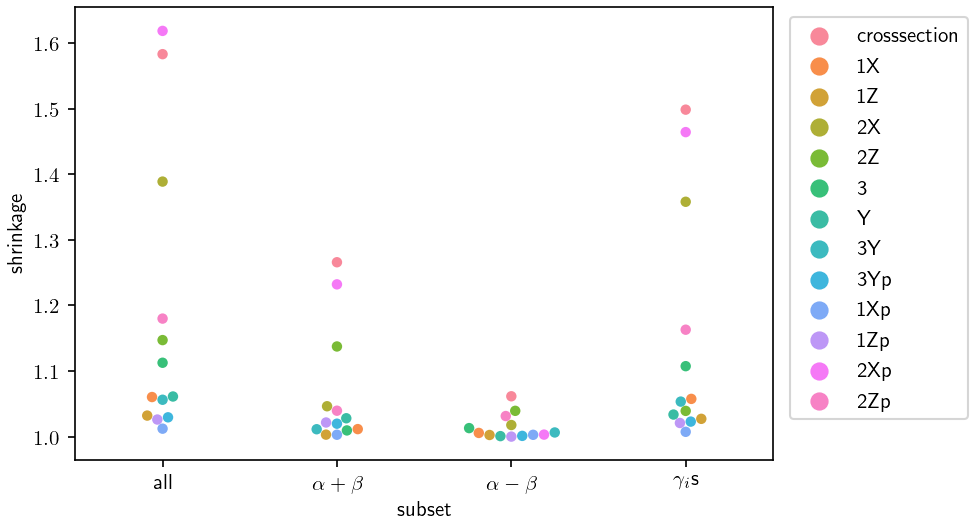

In [51]:
sns.swarmplot(x='subset', y='shrinkage', data=bests_npts, hue='observable')
plt.legend().set_bbox_to_anchor((1.01, 1))

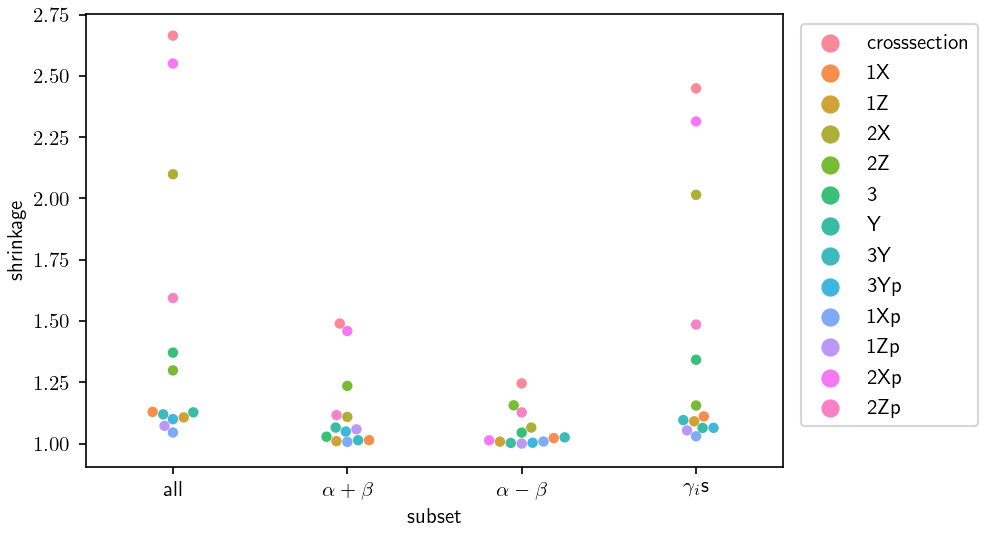

In [114]:
sns.swarmplot(x='subset', y='shrinkage', data=bests_npts, hue='observable')
plt.legend().set_bbox_to_anchor((1.01, 1))

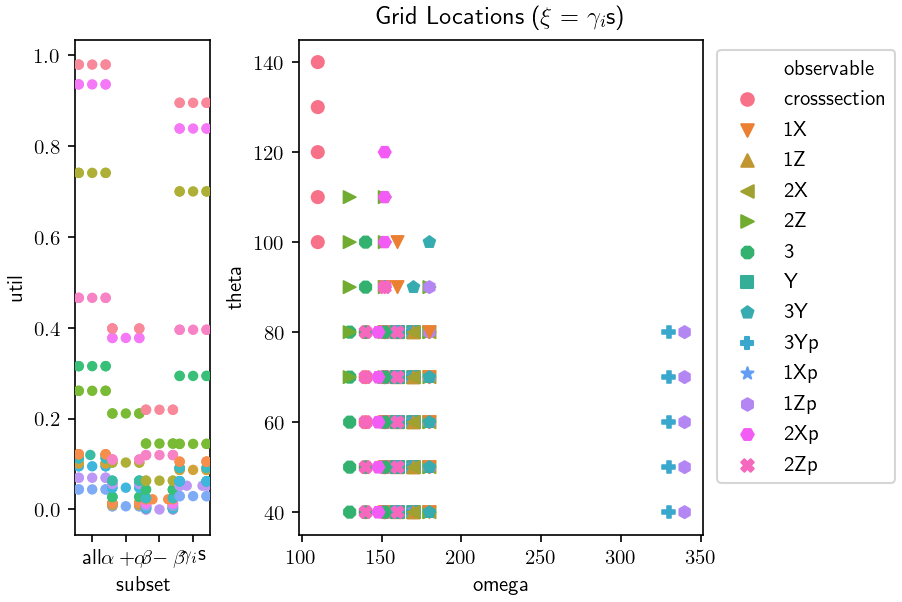

In [106]:
markers2 = ['o', 'v', '^', '<', '>', '8', 's', 'p', 'P', '*', 'h', 'H', 'X']

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig = plt.figure(constrained_layout=True)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs1[0, 1:])
ax2 = fig.add_subplot(gs1[0, 0])

sns.scatterplot(x='omega', y='theta', data=bests_df_flat, hue='observable', style='observable',
                markers=markers2, facecolor='white', edgecolor=None, ax=ax1)
sns.swarmplot(x='subset', y='util', data=bests_df_flat, hue='observable', ax=ax2)

ax1.set_title(fr'Grid Locations ($\xi =$ {subset_name})')
ax2.legend().remove()
ax1.legend().set_bbox_to_anchor((1.01, 1))
fig.savefig(f'figures/grids_and_utilities_trunc_subset-{subset_savenames[subset_name]}.pdf')

In [ ]:
plt.scatter(np.linspace(0, 1, 10), np.linspace(0, 1, 10), edgecolors='k', facecolors='none')

In [ ]:
import matplotlib as mpl

In [ ]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '1', '2', '3', '4', 'P', '*']

In [ ]:
plot_kwargs = {
    'crosssection': dict(fillstyle='none', marker='o'),
}

In [ ]:
fig, ax = plt.subplots()
# ax.plot(X_reduced[:, 0], X_reduced[:, 1], ls='', marker=',', c='k')
for i, obs in enumerate(bests):
    ax.plot(bests[obs]['omega'], bests[obs]['theta'], ls='', marker=markers[i], fillstyle='none', label=obs)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

In [ ]:
X_reduced[best_idxs]